# Figure: Differences at global scale

- UMAP of sample taxonomic dists
- UMAP of sample functional distances
- Taxonomic clustering?
- Column plots of continent differential abundances (PCA better?)


In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

## UMAP of sample taxonomic dists

In [20]:
taxa = core_tabler.taxonomy(normalize=True).fillna(0)

taxa_umap = umap(taxa > 0, n_neighbors=100)
taxa_umap['continent'] = [str(el) for el in core_tabler.metadata['continent'].loc[taxa.index]]
print(taxa.shape)

(3639, 4424)


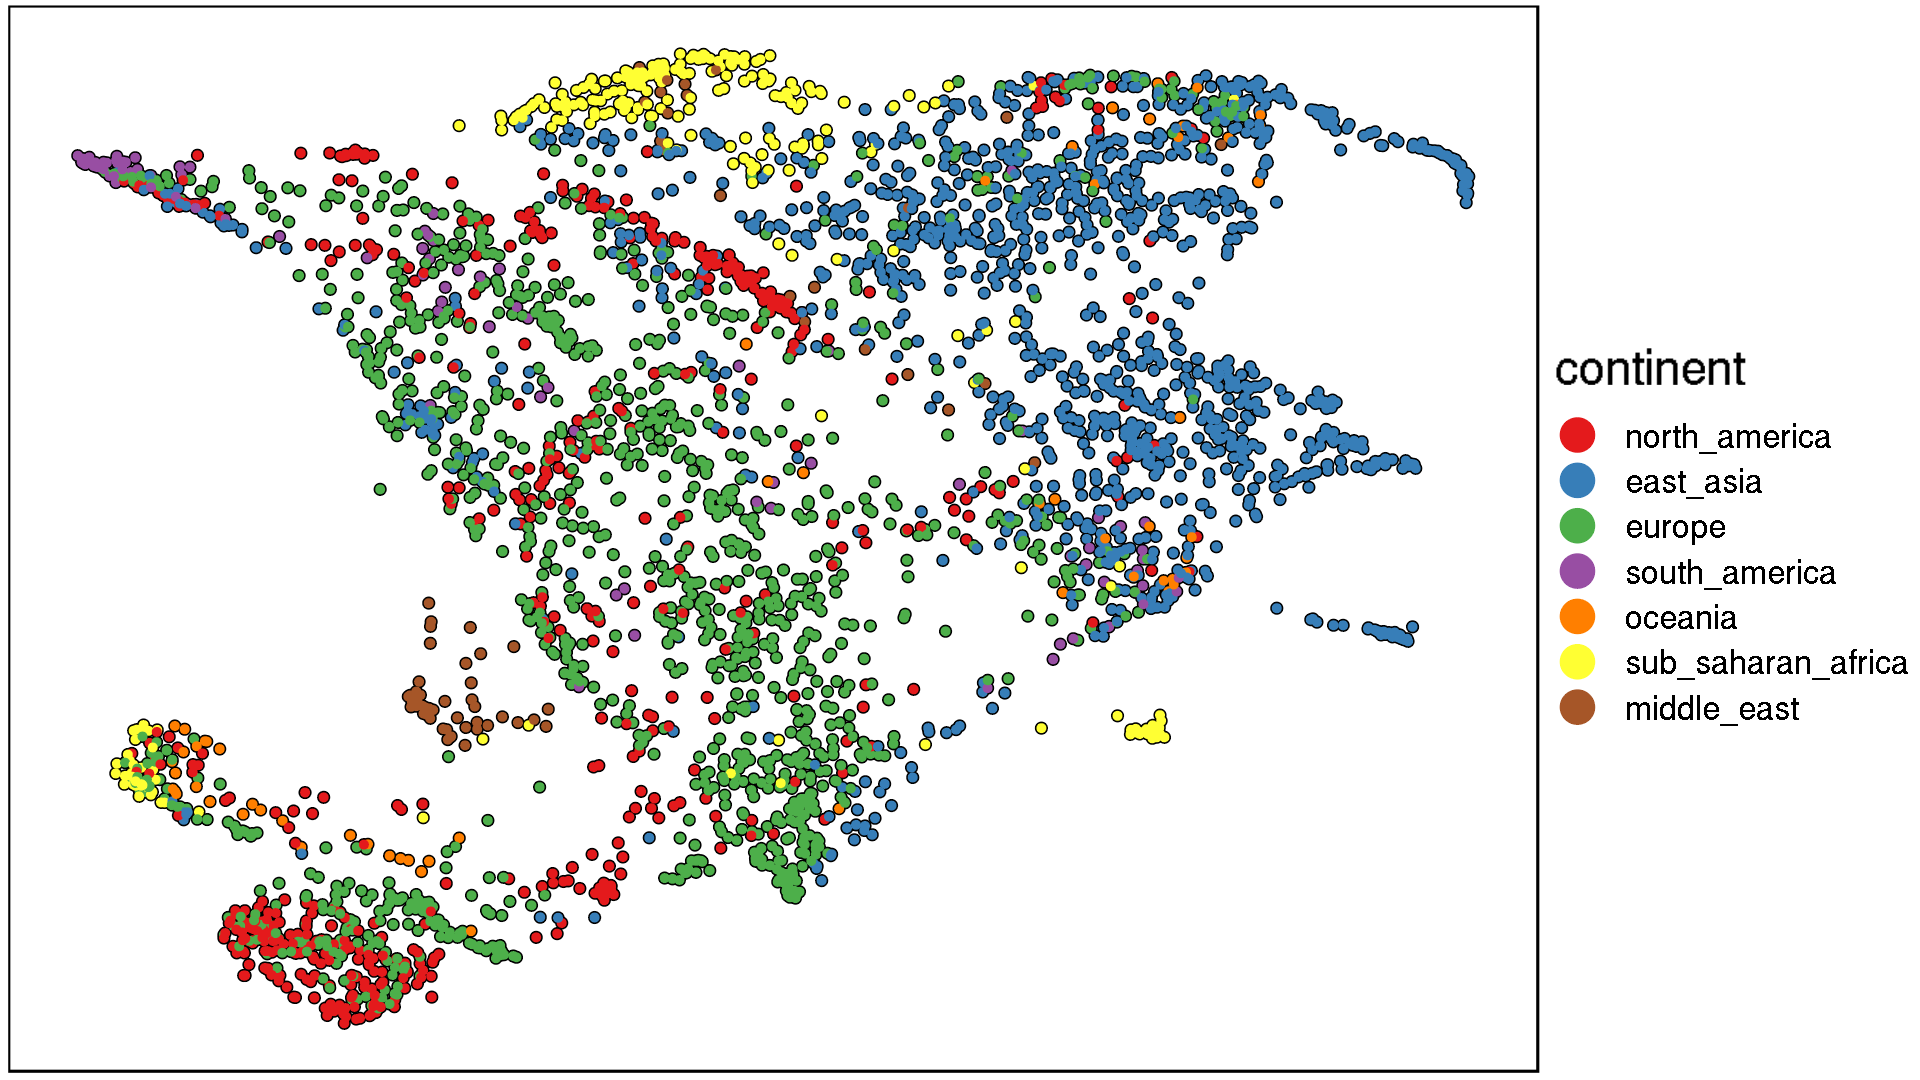

In [23]:
%%R -i taxa_umap -w 1920 -h 1080

taxa_umap$continent = ordered(
    taxa_umap$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
taxa_umap = taxa_umap[taxa_umap$continent != '0',]
taxa_umap = taxa_umap[!is.na(taxa_umap$continent),]
ggplot(taxa_umap, aes(x=C0, y=C1, color=continent)) +
    geom_point(size=5.5, colour = "black") +
    geom_point(size=4) +
    #geom_density_2d(size=1, color='lightgrey') +
    theme_minimal() +
    #stat_ellipse(size=2, level=0.95) +
    scale_color_brewer(palette = "Set1", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    coord_flip() +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

In [24]:
city_metadata = pd.read_csv('/home/dcdanko/Dropbox/resources_and_shared/metasub_data_packets/metasub_data_packet_v1_0/metadata/city_metadata.csv', index_col=0)

taxa = core_tabler.taxonomy(normalize=True)
taxa_major_cities = taxa.groupby(by=core_tabler.metadata['city']).filter(lambda tbl: tbl.shape[0] >= 16)
city_groups = taxa_major_cities.groupby(by=core_tabler.metadata['city'])

def prevalence(df, thresh=0, count=False):
    """Return the prevalence of each column in a dataframe."""
    return (df > thresh).sum(axis=0) / (1 if count else df.shape[0])

city_prevalence = city_groups.apply(prevalence)
median_taxa_prevalence_in_cities = city_prevalence.median(axis=0)

city_sums = city_prevalence.sum(axis=1)
taxa_sums = city_prevalence.sum(axis=0)
prob_tc = city_prevalence / taxa_sums
prob_ct = (city_prevalence.T / city_sums).T
indicator_scores = prob_tc * prob_ct
indicator_scores_cities = indicator_scores.T.melt()
indicator_scores_cities['continent'] = [str(el) for el in city_metadata.loc[indicator_scores_cities['city'] ,'continent']]
indicator_scores_cities = indicator_scores_cities.query('city != "antarctica"')
indicator_scores_cities = indicator_scores_cities.query('city != "other_control"')
indicator_scores_cities = indicator_scores_cities.dropna()

indicator_scores_cities.head()

,city,value,continent
0,barcelona,2.333376e-07,europe
1,barcelona,3.342061e-07,europe
2,barcelona,2.013649e-05,europe
3,barcelona,8.403826e-06,europe
4,barcelona,1.297929e-05,europe


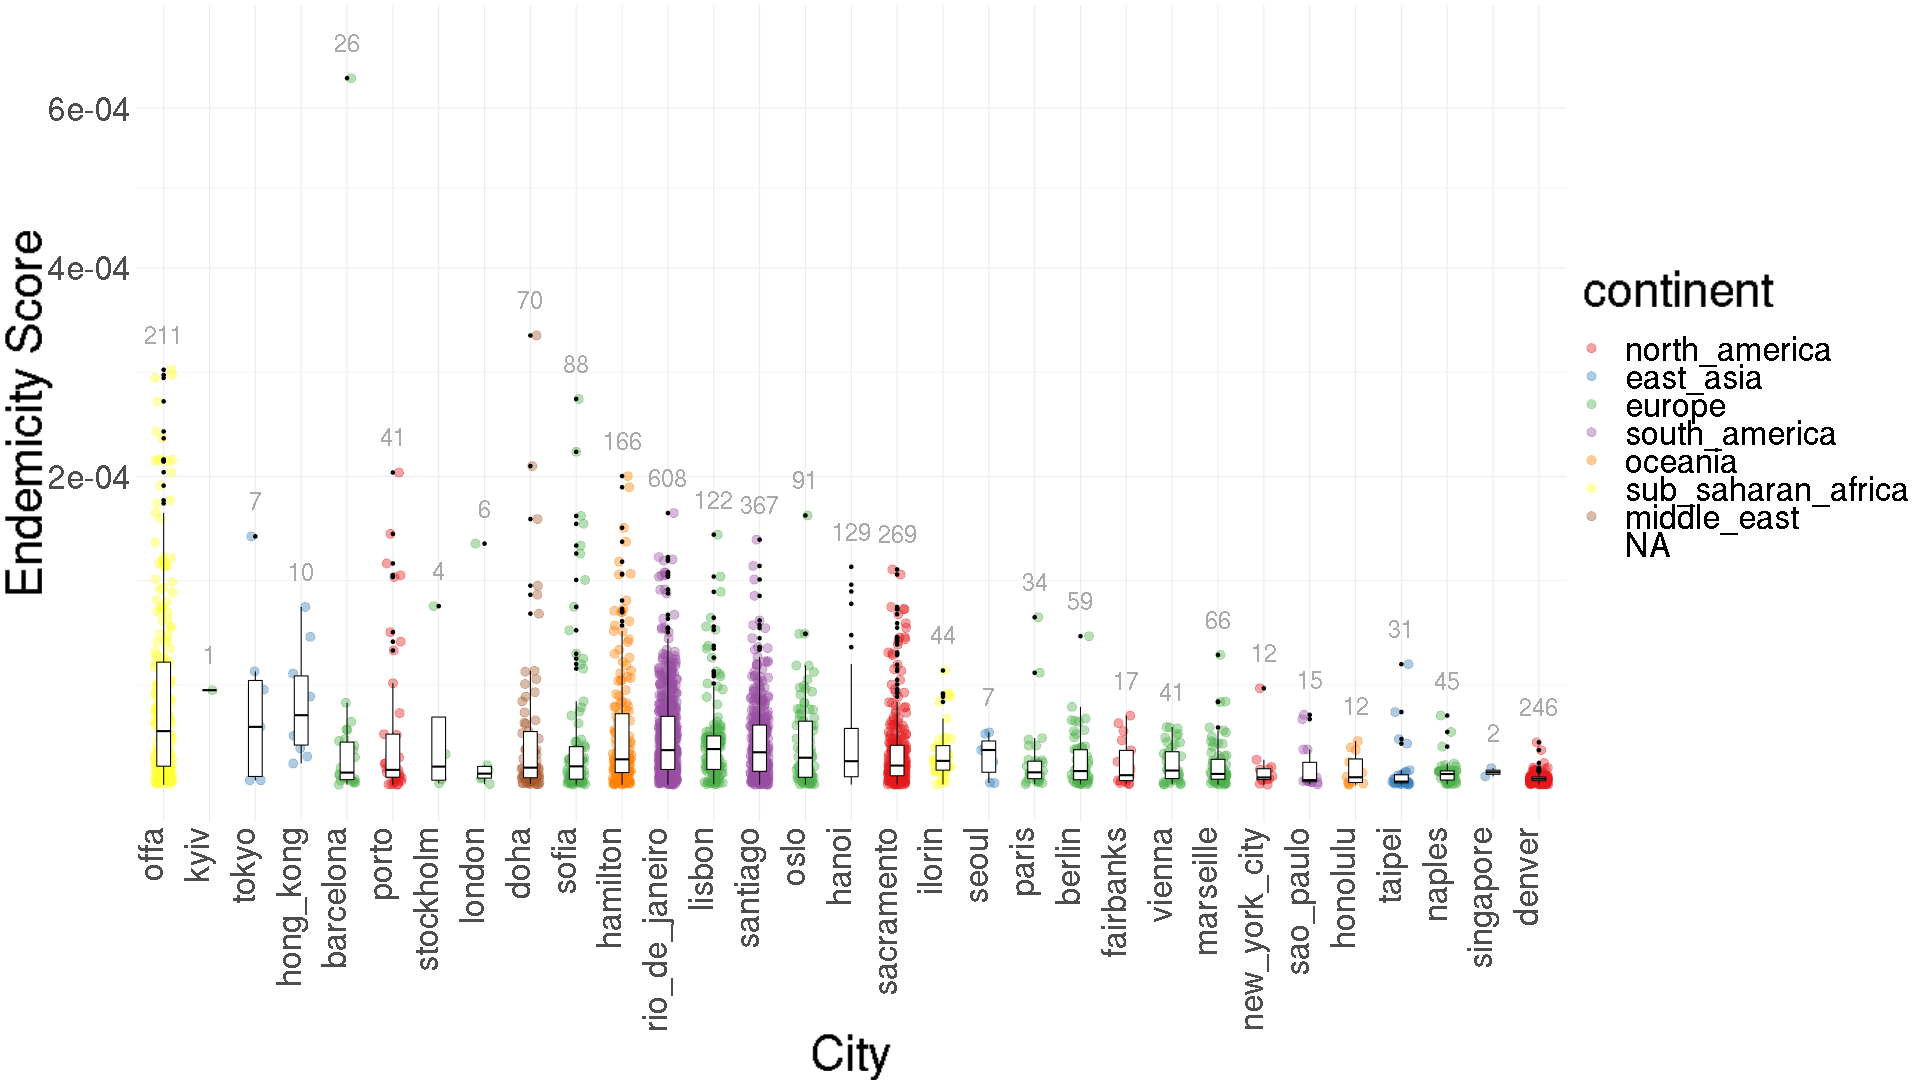

In [25]:
%%R -i indicator_scores_cities -i city_metadata --height 1080 --width 1920

n_fun <- function(x){
  return(data.frame(y=max(x) + 0.001, label=length(x)))
}
n_fun2 <- function(x){
  return(data.frame(y=mean(x) + 0.001, label=length(x)))
}
indicator_scores = indicator_scores_cities[indicator_scores_cities['value'] > 0.00003,]
indicator_scores['city'] = reorder(indicator_scores$city, indicator_scores$value, function(x){-mean(x)})
continents = c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
indicator_scores$continent = ordered(
    indicator_scores$continent,
    levels=continents
)
ggplot(indicator_scores, aes(x=city, y=value, fill=continent, color=continent)) +
    geom_jitter(width=0.2, size=4, alpha=0.4) +
    geom_boxplot(fill='white', width=0.3, color='black') +
    scale_y_sqrt() +
    theme_minimal() +
    ylab('Endemicity Score') + 
    xlab('City') + 
    scale_color_brewer(palette='Set1') +
    stat_summary(fun.data = n_fun, geom = "text", color='darkgrey', size=8) +
    theme(
        text=element_text(size=50),
        axis.text.x=element_text(angle = 90, hjust = 1, vjust=-0.025)
    )

## Taxonomic clustering

In [35]:
from scipy.cluster.hierarchy import linkage, cophenet, leaves_list
from scipy.spatial.distance import squareform, pdist, jensenshannon

phyla = pd.read_csv(core_tabler.packet_dir + '/taxonomy/refseq.krakenhll_phyla.csv', index_col=0).fillna(0)


#phyla = phyla.sample(1000)
phyla = (phyla.T / phyla.T.sum()).T.dropna()
print(phyla.shape)
low_abundance_phyla = phyla.columns[100 * phyla.mean() < 1]
low_abundance = phyla[low_abundance_phyla].sum(axis=1)
phyla = phyla.drop(columns=low_abundance_phyla)
phyla['Other'] = low_abundance
print(phyla.shape)

phyla_dist = core_tabler.beta_diversity(phyla, metric='jensenshannon')
print(phyla_dist.shape)
Z = linkage(squareform(phyla_dist), 'average')
sample_order = phyla.index[leaves_list(Z)]
print(cophenet(Z, squareform(phyla_dist))[0])

phyla['sample'] = phyla.index
phyla['continent'] = core_tabler.metadata['continent']
phyla['continent'] = [str(el) for el in phyla['continent']]
phyla = phyla.melt(id_vars=['sample', 'continent'])
phyla = phyla.dropna()

phyla.head()

(4427, 38)
(4427, 5)
(4427, 4427)
0.7327456273642506


,sample,continent,variable,value
0,haib17CEM4890_H2NYMCCXY_SL254769,sub_saharan_africa,Actinobacteria,0.053044
1,haib17CEM4890_H2NYMCCXY_SL254770,sub_saharan_africa,Actinobacteria,0.003460
2,haib17CEM4890_H2NYMCCXY_SL254771,sub_saharan_africa,Actinobacteria,0.001604
3,haib17CEM4890_H2NYMCCXY_SL254772,sub_saharan_africa,Actinobacteria,0.008892
4,haib17CEM4890_H2NYMCCXY_SL254773,north_america,Actinobacteria,0.279156


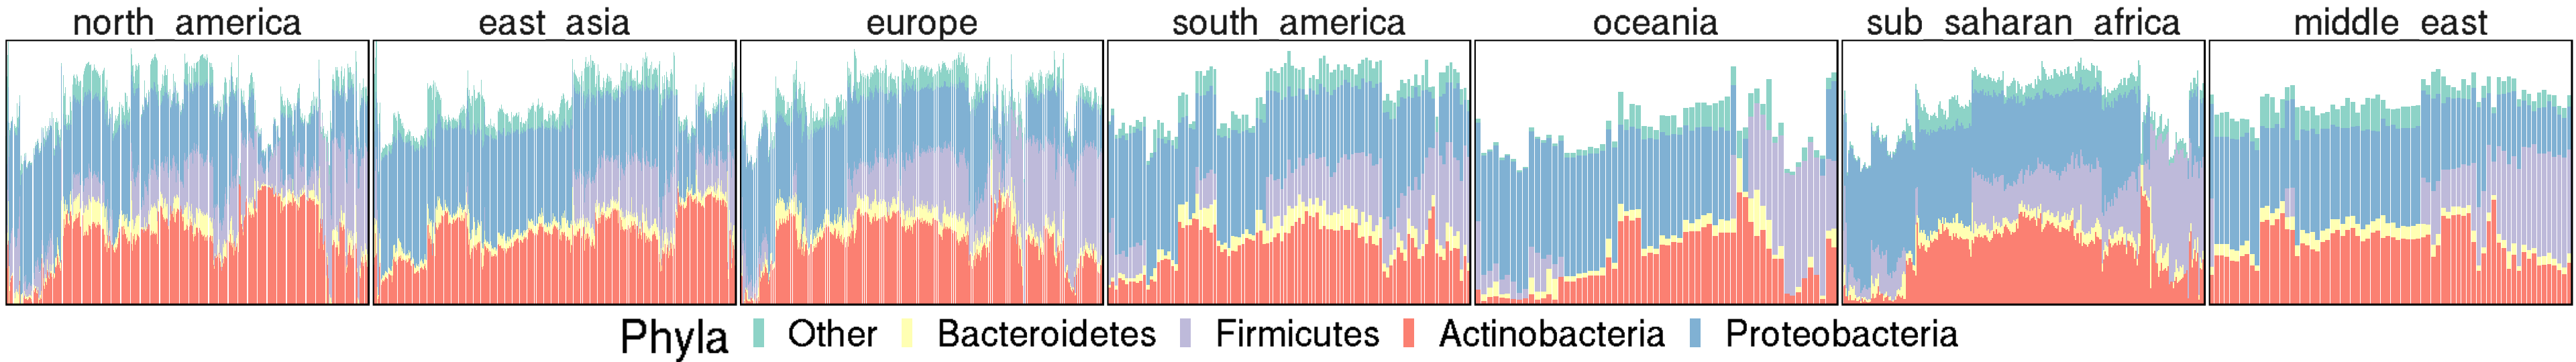

In [37]:
%%R -i phyla -i sample_order -w 3840 -h 540

ph = c('Proteobacteria', 'Actinobacteria', 'Firmicutes', 'Bacteroidetes', 'Euryarchaeota', 'Other')
phyla$sample = ordered(phyla$sample, levels=sample_order)
phyla$variable = ordered(phyla$variable, levels=rev(ph))

phyla$continent = ordered(
    phyla$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
phyla = phyla[phyla$continent != '0',]
phyla = phyla[!is.na(phyla$continent),]
ggplot(phyla, aes(x=sample, y=value, fill=variable, group=continent)) +
    geom_col() +
    facet_grid(.~continent, scales="free") +
    scale_fill_brewer(palette = "Set3", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    scale_y_sqrt(expand = c(0,0)) +
    labs(fill='Phyla') +
    theme(
        text = element_text(size=70),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

In [39]:
import networkx as nx

paths = core_tabler.pathways()

mypaths = paths[[el for el in paths.columns if 'unclassified' not in el and 'UNINTEG' not in el]]
print(mypaths.shape)
co = mypaths.corr()
co['path_1'] = co.index
co = co.melt(id_vars=['path_1'])
co.columns = ['path_1', 'path_2', 'value']
co = co.query('value > = 0.75')
print(co.shape)

def wordcloud(paths):
    tbl = {}
    for path in paths:
        for word in path.split():
            tbl[word] = 1 + tbl.get(word, 0)
            
    otbl = sorted([(k, v) for k, v in tbl.items()], key=lambda x: -x[1])
    tbl = [k for k, v in otbl if v > 1]
    tbl = [k for k in tbl if len(k) > 3 and 'PWY' not in k]
    if len(tbl) < 3:
        tbl = [k for k, _ in otbl if 'PWY' not in k]
    return tbl[:10]
            

G = nx.Graph()
for _, row in co.iterrows():
    G.add_edge(row['path_1'], row['path_2'])

n, p = 0, 0
comps = [comp for comp in nx.connected_components(G) if len(comp) > 1]
wcs = {f'COMP_{i}': (comp, wordcloud(comp)) for i, comp in enumerate(comps)}
for name, (comp, wc) in wcs.items():
    if len(comp) == 1:
        continue
    n += 1
    p += len(comp)
    these_paths = mypaths[comp].sum(axis=1)
    mypaths = mypaths.drop(columns=comp)
    mypaths[name] = these_paths
    
mypaths = (mypaths.T / mypaths.T.sum()).T.dropna()
low_abundance_paths = mypaths.columns[mypaths.mean() < 0.01]
low_abundance = mypaths[low_abundance_paths].sum(axis=1)
mypaths = mypaths.drop(columns=low_abundance_paths)
mypaths['Other'] = low_abundance
print(mypaths.shape)

print(f'Components {n}, Pathways {p}')
mypaths.head()

(3447, 566)
(1632, 3)
(3447, 10)
Components 69, Pathways 283


,PWY-3781: aerobic respiration I (cytochrome c),COMP_0,COMP_1,COMP_2,COMP_3,COMP_6,COMP_8,COMP_10,COMP_11,Other
haib18CEM5453_HNHKFCCXY_SL346071,0.013448,0.451724,0.032891,0.018371,0.009173,0.008419,0.016181,0.024207,0.009930,0.415655
haib17CEM5241_HMGMHCCXY_SL343369,0.009045,0.470055,0.020682,0.055092,0.008584,0.027238,0.002814,0.000000,0.031962,0.374527
haib18CEM5453_HMCMJCCXY_SL336242,0.004178,0.436725,0.022320,0.037767,0.011846,0.018940,0.013050,0.024821,0.025613,0.404740
haib17CEM4890_H75CGCCXY_SL263714,0.006926,0.374064,0.034836,0.021029,0.037089,0.009921,0.017313,0.032146,0.024660,0.442016
haib18CEM5453_HNHKFCCXY_SL345519,0.009949,0.365402,0.034679,0.015988,0.017772,0.007983,0.016608,0.023132,0.017659,0.490829


In [40]:
for key in mypaths.columns:
    if key in wcs:
        print(f'{key}: {wcs[key][1]}')

COMP_0: ['biosynthesis', 'superpathway', 'novo', 'acid', 'fatty', 'cycle', 'adenosine', 'guanosine', 'nucleotides', 'ribonucleotides']
COMP_1: ['biosynthesis', 'L-arginine', '(via']
COMP_2: ['pyrimidine', 'deoxyribonucleotides', 'novo', 'biosynthesis']
COMP_3: ['biosynthesis', 'CDP-diacylglycerol', 'phosphatidylglycerol']
COMP_6: ['N10-formyl-tetrahydrofolate', 'biosynthesis', 'folate', 'transformations', 'II']
COMP_8: ['glycolysis', '(from', '6-phosphate)']
COMP_10: ['biosynthesis', 'superpathway', 'L-methionine']
COMP_11: ['biosynthesis', "inosine-5'-phosphate", 'I', 'III', 'superpathway', 'of', 'purine', 'nucleotides', 'de', 'novo']


In [44]:
cats = {
    'PWY-3781: aerobic respiration I (cytochrome c)': 'Aerobic Respiration',
    'COMP_0': 'Fatty Acid Biosynthesis',
    'COMP_1': 'L-arginine Biosynthesis',
    'COMP_2': 'Pyrimidine Biosynthesis',
    'COMP_3': 'Glycerol Biosynthesis',
    'COMP_8': 'Glycolysis',
    'COMP_6': 'Folate Biosynthesis',
    'COMP_10': 'Methionine Biosynthesis',
    'COMP_11': 'Purine Biosynthesis',
}
foo = mypaths.rename(columns=cats)
foo['sample'] = foo.index
foo['continent'] = core_tabler.metadata['continent']
foo['continent'] = [str(el) for el in foo['continent']]
foo = foo.melt(id_vars=['sample', 'continent'])
foo = foo.dropna()
print(foo.shape)
foo.head()

(34470, 4)


,sample,continent,variable,value
0,haib18CEM5453_HNHKFCCXY_SL346071,east_asia,Aerobic Respiration,0.013448
1,haib17CEM5241_HMGMHCCXY_SL343369,east_asia,Aerobic Respiration,0.009045
2,haib18CEM5453_HMCMJCCXY_SL336242,east_asia,Aerobic Respiration,0.004178
3,haib17CEM4890_H75CGCCXY_SL263714,north_america,Aerobic Respiration,0.006926
4,haib18CEM5453_HNHKFCCXY_SL345519,east_asia,Aerobic Respiration,0.009949


In [45]:
foo['variable'].unique()

array(['Aerobic Respiration', 'Fatty Acid Biosynthesis',
       'L-arginine Biosynthesis', 'Pyrimidine Biosynthesis',
       'Glycerol Biosynthesis', 'Folate Biosynthesis', 'Glycolysis',
       'Methionine Biosynthesis', 'Purine Biosynthesis', 'Other'],
      dtype=object)

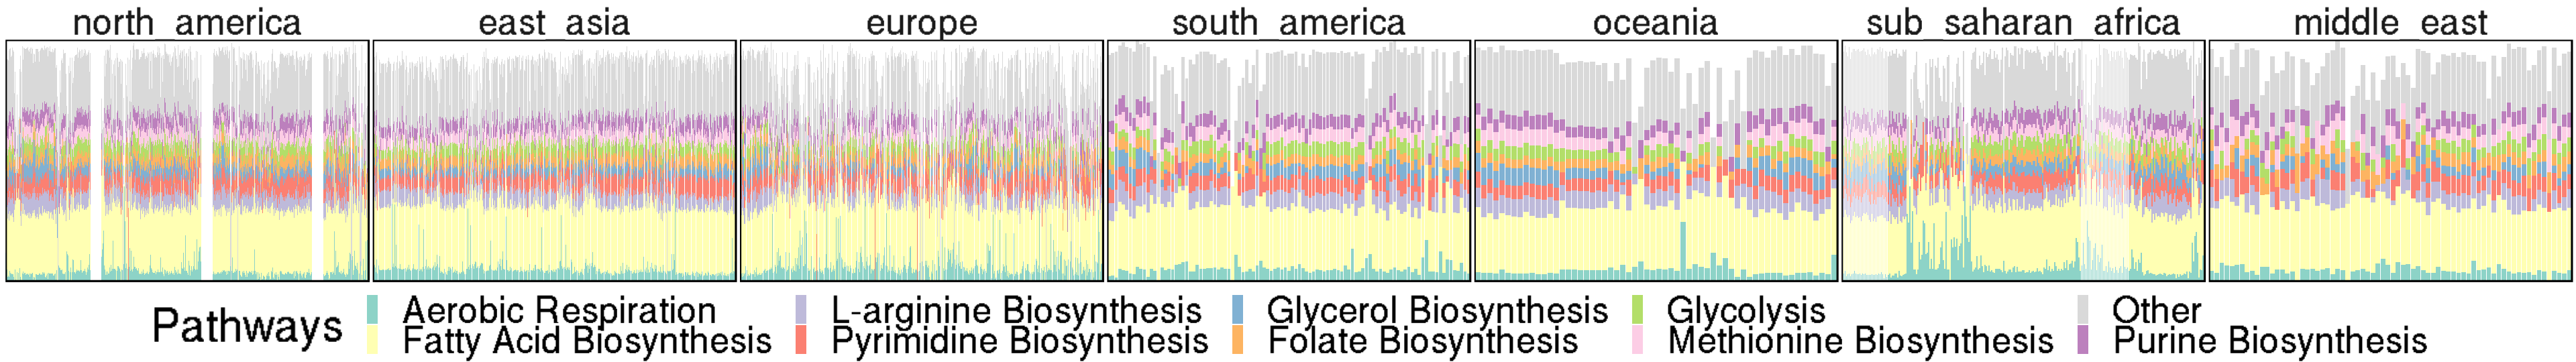

In [49]:
%%R -i foo -i sample_order -w 3840 -h 540

ph = c('Aerobic Respiration', 'Fatty Acid Biosynthesis',
       'L-arginine Biosynthesis', 'Pyrimidine Biosynthesis',
       'Glycerol Biosynthesis', 'Folate Biosynthesis', 'Glycolysis',
       'Methionine Biosynthesis',  'Other', 'Purine Biosynthesis')
foo$sample = ordered(foo$sample, levels=sample_order[sample_order %in% foo$sample])
foo$variable = ordered(foo$variable, levels=ph)

foo$continent = ordered(
    foo$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
foo = foo[foo$continent != '0',]
foo = foo[!is.na(foo$continent),]
ggplot(foo, aes(x=sample, y=value, fill=variable, group=continent)) +
    geom_col() +
    facet_grid(.~continent, scales="free") +
    scale_fill_brewer(palette = "Set3", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    scale_y_sqrt(expand = c(0,0)) +
    labs(fill='Pathways') +
    theme(
        text = element_text(size=70),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

In [54]:
from scipy.cluster.hierarchy import linkage, cophenet, leaves_list
from scipy.spatial.distance import squareform, pdist, jensenshannon

amrs = core_tabler.amrs(kind='class', remove_zero_rows=False).drop(columns=['Elfamycins']).dropna()
amrs = (amrs.T / (amrs.T.sum() + 0.000001)).T

print(amrs.shape)
low_abundance_amrs = amrs.columns[100 * amrs.mean() < 5]
low_abundance = amrs[low_abundance_amrs].sum(axis=1)
amrs = amrs.drop(columns=low_abundance_amrs)
amrs['Other'] = low_abundance
print(amrs.shape)
amrs = amrs.dropna()


amrs['sample'] = amrs.index
amrs['continent'] = core_tabler.metadata['continent']
amrs['continent'] = [str(el) for el in amrs['continent']]
amrs = amrs.melt(id_vars=['sample', 'continent'])
amrs = amrs.dropna()

print(amrs['variable'].unique().tolist())

amrs.head()

(3568, 20)
(3568, 6)
['MLS', 'Multi-drug resistance', 'Phenicol', 'Rifampin', 'betalactams', 'Other']


,sample,continent,variable,value
0,haib18CEM5453_HNHKFCCXY_SL346071,east_asia,MLS,0.00000
1,haib17CEM5241_HMGMHCCXY_SL343369,east_asia,MLS,0.00000
2,haib18CEM5453_HMCMJCCXY_SL336242,east_asia,MLS,0.00000
3,haib17CEM4890_H75CGCCXY_SL263714,north_america,MLS,0.01321
4,haib18CEM5453_HNHKFCCXY_SL345519,east_asia,MLS,0.00000


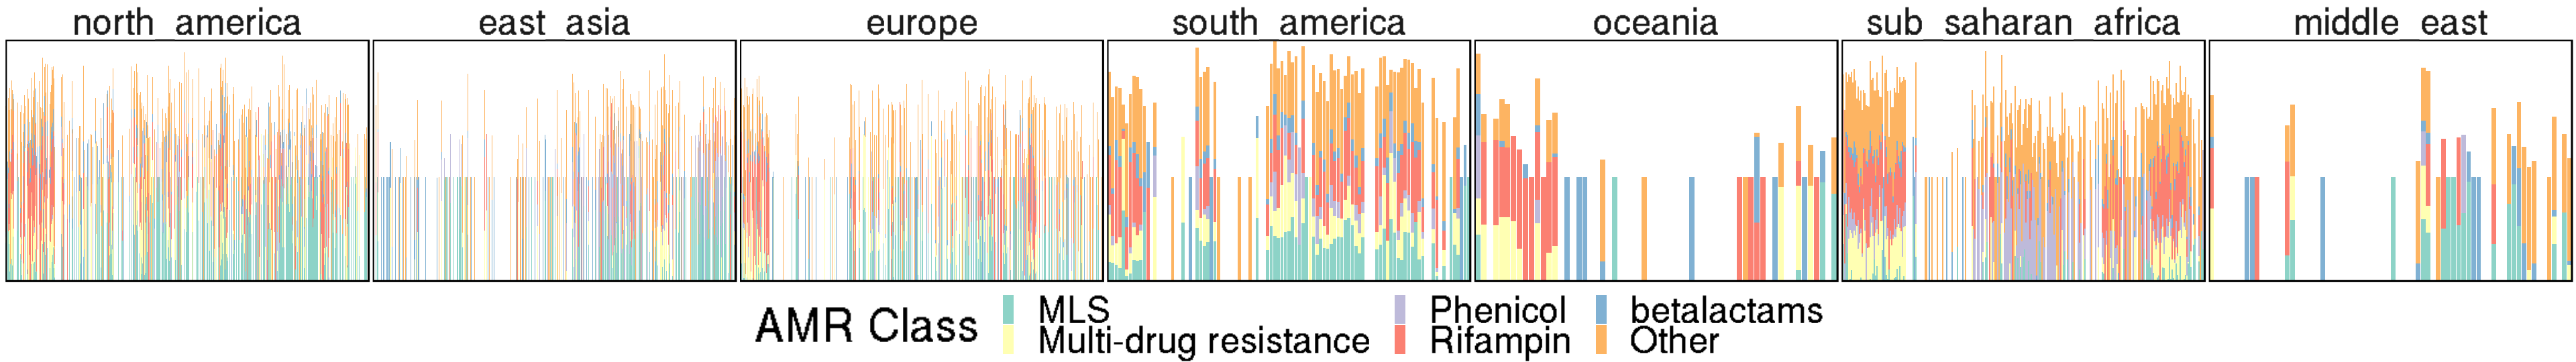

In [55]:
%%R -i amrs -i sample_order -w 3840 -h 540

ph = c('Aminoglycosides', 'MLS', 'Multi-drug resistance', 'Phenicol', 'Rifampin', 'betalactams', 'Other')
amrs$sample = ordered(amrs$sample, levels=sample_order)
amrs$variable = ordered(amrs$variable, levels=ph)

amrs$continent = ordered(
    amrs$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
amrs = amrs[amrs$continent != '0',]
amrs = amrs[!is.na(amrs$continent),]
amrs = amrs[!is.na(amrs$sample),]

ggplot(amrs, aes(x=sample, y=value, fill=variable, group=continent)) +
    geom_col() +
    facet_grid(.~continent, scales="free") +
    scale_fill_brewer(palette = "Set3", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_minimal() +
    scale_y_sqrt(expand = c(0,0)) +
    labs(fill='AMR Class') +
    theme(
        text = element_text(size=70),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )

In [62]:
%%R -i amrs -i sample_order -w 3840 -h 540

ph = c('Proteobacteria', 'Actinobacteria', 'Firmicutes', 'Bacteroidetes', 'Euryarchaeota', 'Other')
amrs$sample = ordered(amrs$sample, levels=sample_order)
amrs$continent = ordered(
    amrs$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
amrs = amrs[amrs$continent != '0',]
amrs = amrs[!is.na(amrs$continent),]
amrs = amrs[!is.na(amrs$sample),]

head(amrs)

                            sample          continent        variable     value
1 haib17CEM4890_H75CGCCXY_SL263686            oceania Aminoglycosides 0.0000000
2 haib18CEM5453_HMGN5CCXY_SL344642 sub_saharan_africa Aminoglycosides 0.3799497
3 haib18CEM5453_HT5YVCCXY_SL357298          east_asia Aminoglycosides 1.0000000
5 haib17CEM5106_HCY5HCCXY_SL270982             europe Aminoglycosides 0.0000000
6 haib18CEM5453_HT5YVCCXY_SL357513          east_asia Aminoglycosides 0.0000000
7 haib17CEM5106_HCCGHCCXY_SL270402             europe Aminoglycosides 0.0000000


In [127]:
paths = core_tabler.pathways()
paths = paths.sample(500)
taxa = core_tabler.taxonomy(normalize=True)
taxa = taxa.loc[paths.index]

taxa_dists = pd.Series(squareform(core_tabler.beta_diversity(taxa, metric='jensenshannon')))
path_dists = pd.Series(squareform(core_tabler.beta_diversity(paths, metric='jensenshannon')))

In [136]:
print(taxa_dists.mean())
print(path_dists.mean())

from scipy.stats import ttest_ind

ttest_ind(taxa_dists, path_dists, equal_var=False)

0.6164036234780911
0.09879082670015882


Ttest_indResult(statistic=1272.9526743188248, pvalue=0.0)

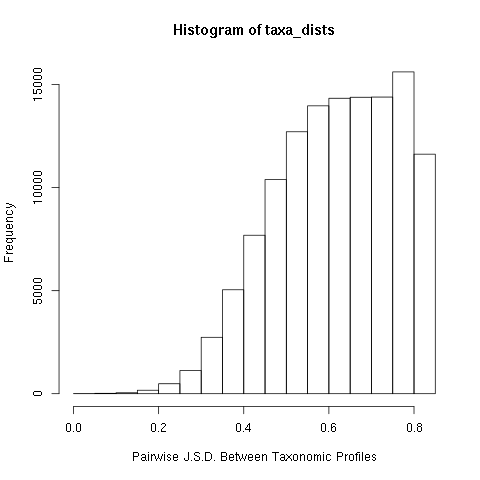

In [135]:
%%R -i taxa_dists

hist(taxa_dists, xlab='Pairwise J.S.D. Between Taxonomic Profiles')

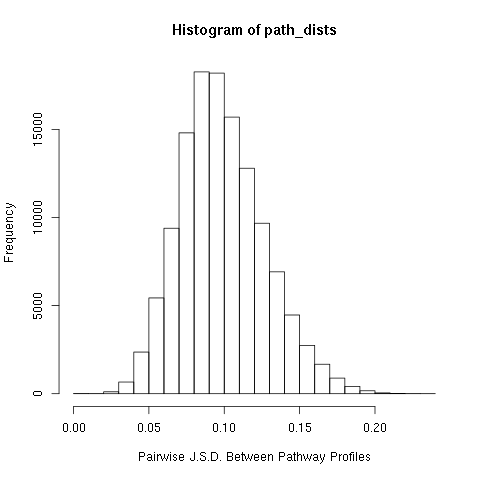

In [134]:
%%R -i path_dists

hist(path_dists, xlab='Pairwise J.S.D. Between Pathway Profiles')

## Supplementary

## UMAP of sample functional distances

In [52]:
paths = core_tabler.pathways()
umap_paths = umap(paths > 0, n_neighbors=100)
umap_paths['continent'] = [str(el) for el in core_tabler.metadata['continent'].loc[paths.index]]



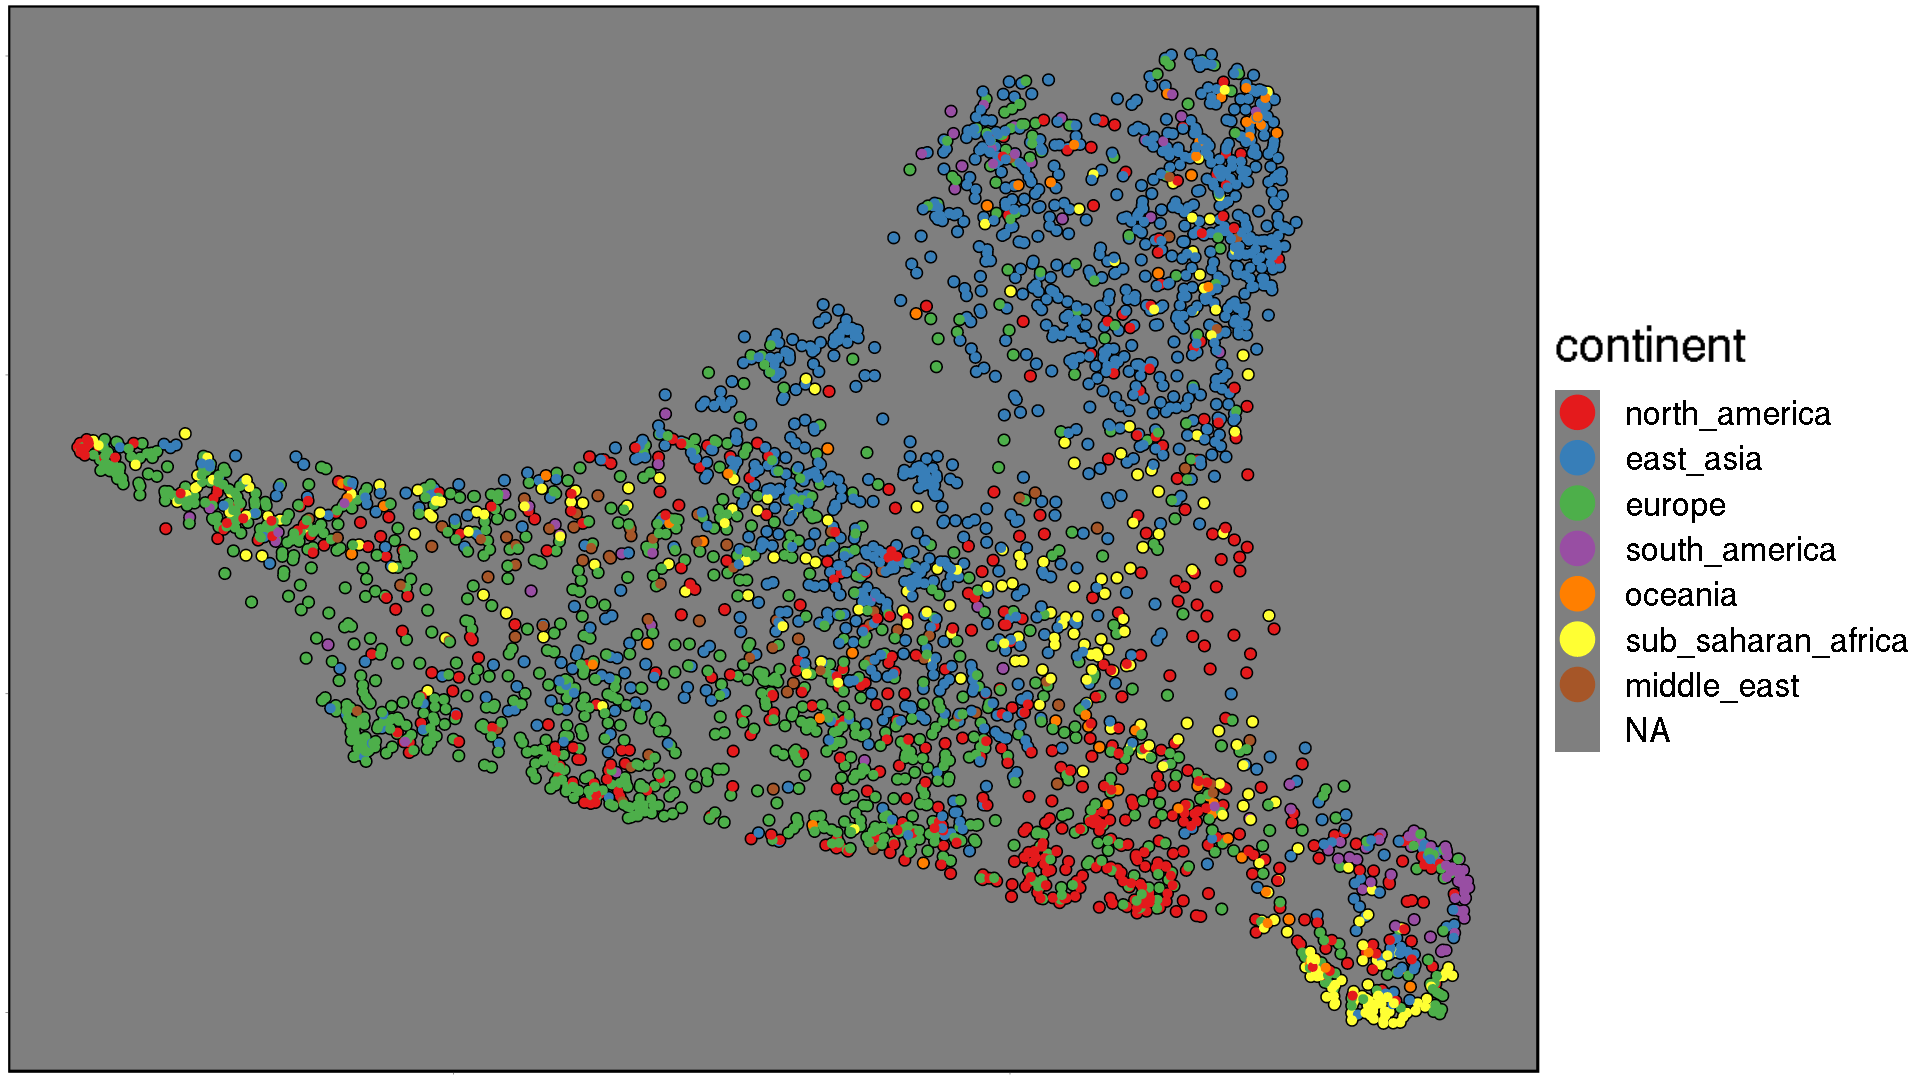

In [53]:
%%R -i umap_paths -w 1920 -h 1080

umap_paths$continent = ordered(
    umap_paths$continent,
    levels=c(
        '0',
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
))
ggplot(umap_paths[umap_paths$continent != '0',], aes(x=C0, y=C1, color=continent)) +
    geom_point(size=5.5, colour = "black") +
    geom_point(size=4) +
    #geom_density_2d(size=1, color='lightgrey') +
    theme_minimal() +
    #stat_ellipse(size=2, level=0.95) +
    scale_color_brewer(palette = "Set1", direction=1) +
    guides(color = guide_legend(override.aes=list(size=16))) +
    theme_dark() +
    theme(
        text = element_text(size=50),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='right',
        axis.text.x=element_blank(),
        axis.title.x=element_blank(),
        axis.text.y=element_blank(),
        axis.title.y=element_blank(),
        panel.border = element_rect(colour="black", fill=NA, size=2),
    )